In [226]:
import pandas as pd
import numpy as np
np.random.seed(42)
%matplotlib inline
import seaborn as sns
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, Bidirectional, Dropout, LSTM, GlobalMaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

In [140]:
data = pd.read_csv("./train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [213]:
test = pd.read_csv("./test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78035 entries, 0 to 78034
Data columns (total 15 columns):
id                                              78035 non-null object
teacher_id                                      78035 non-null object
teacher_prefix                                  78034 non-null object
school_state                                    78035 non-null object
project_submitted_datetime                      78035 non-null object
project_grade_category                          78035 non-null object
project_subject_categories                      78035 non-null object
project_subject_subcategories                   78035 non-null object
project_title                                   78035 non-null object
project_essay_1                                 78035 non-null object
project_essay_2                                 78035 non-null object
project_essay_3                                 2704 non-null object
project_essay_4                                 2704

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


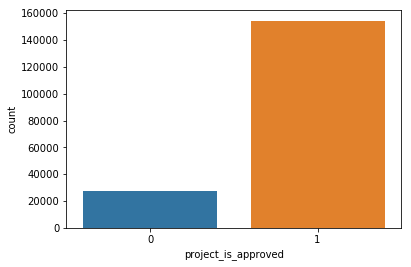

In [141]:
sns.countplot(data.project_is_approved)

In [142]:
data.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [163]:
# punct_remover = str.maketrans('', '', string.punctuation)
punct_remover = str.maketrans(string.punctuation, ' '*len(string.punctuation))
def text_cleanse(text):
    return text.replace("\\r", " ").replace("\\n", " ").replace("\\t", " ").replace("\\","") \
.translate(punct_remover).replace(".","").lower()

In [164]:
data["project_title_proc"] = [text_cleanse(text) for text in data.project_title]

In [165]:
max([len(text) for text in data.project_title_proc])

125

In [169]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.project_title_proc)
vocab_size = len(tokenizer.word_index) + 1

In [170]:
enc_docs = tokenizer.texts_to_sequences(data.project_title_proc)

In [171]:
max_length = 125
padded_docs = pad_sequences(enc_docs, maxlen = max_length, padding = 'post')

In [243]:
embeddings_index = dict()
f = open('./glove.6B.300d.txt', encoding="UTF-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [244]:
dims = 300
embedding_matrix = np.zeros((vocab_size, dims))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [245]:
model = Sequential()
e = Embedding(vocab_size, dims, weights = [embedding_matrix], input_length = max_length, trainable = False)
model.add(e)
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
'''model.add(Bidirectional(LSTM(50, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))'''

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 125, 300)          6410700   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                9632      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 6,420,365
Trainable params: 9,665
Non-trainable params: 6,410,700
_________________________________________________________________


In [246]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, data.project_is_approved, 
                                                    test_size = 0.2, random_state = 42)

In [247]:
train_performance = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Train on 145664 samples, validate on 36416 samples
Epoch 1/10
145664/145664 [==============================] - 13s - loss: 0.4298 - acc: 0.8477 - val_loss: 0.4218 - val_acc: 0.8469

KeyboardInterrupt: 

In [248]:
preds = model.predict(X_test)
print(auc(y_test, preds, reorder=True))

0.772782802582


In [214]:
test["project_title_proc"] = [text_cleanse(text) for text in test.project_title]
enc_test_docs = tokenizer.texts_to_sequences(test.project_title_proc)
padded_test_docs = pad_sequences(enc_test_docs, maxlen = max_length, padding = 'post')

In [249]:
preds = model.predict(padded_test_docs)

In [250]:
test["project_is_approved"] = preds

In [217]:
submission = pd.read_csv("./sample_submission.csv")

In [218]:
submission.head()

,id,project_is_approved
0,p233245,0.847682
1,p096795,0.847682
2,p236235,0.847682
3,p233680,0.847682
4,p171879,0.847682


In [251]:
submission = test[["id", "project_is_approved"]]
submission.head()

,id,project_is_approved
0,p233245,0.807735
1,p096795,0.893739
2,p236235,0.817315
3,p233680,0.862534
4,p171879,0.890089


In [252]:
submission.to_csv("./submission.csv", index=False)